## Projeto Analysis of Diabetes Risk Factor

### Machine Learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Carregando o Dataset pré-processado

In [2]:
df_diabetes_indcators = pd.read_csv("..\\datalake\\processing\\diabetes_indcators.csv", index_col=0)

In [3]:
df_diabetes_indcators.head()

,high_blood_preassure,high_cholesterol,body_mass_index,age,physical_activity_in_past_30_days,physical_illness_injury_days,education,income,diabetes
0,1,1,40.0,9,0,15,4,3,0
1,0,0,25.0,7,1,0,6,1,0
2,1,1,28.0,9,0,30,4,8,0
3,1,0,27.0,11,1,0,3,6,0
4,1,1,24.0,11,1,0,5,4,0


### Transformação de Features

In [4]:
def map_imc_ranges(x):
    if x < 25:
        return 0
    elif x >= 25 and x <= 30:
        return 1
    else:
        return 2

In [5]:
df_diabetes_indcators['body_mass_index'] = df_diabetes_indcators['body_mass_index'].map(lambda x:map_imc_ranges(x))

In [6]:
def map_age_ranges(x):
    if x < 6:
        return 0
    elif x >= 6 and x <= 7:
        return 1
    elif x >= 8 and x <= 9:
        return 2
    else:
        return 3

In [7]:
df_diabetes_indcators['age'] = df_diabetes_indcators['age'].map(lambda x:map_age_ranges(x))

In [8]:
def map_physical_illness_days(x):
    if x < 10:
        return 0
    elif x >= 10 and x <= 20:
        return 1
    else:
        return 2

In [9]:
df_diabetes_indcators['physical_illness_injury_days'] = df_diabetes_indcators['physical_illness_injury_days']\
    .map(lambda x:map_physical_illness_days(x))

In [10]:
def map_education_scale(x):
    if x < 4:
        return 1
    elif x >= 4 and x <= 5:
        return 2
    else:
        return 3

In [11]:
df_diabetes_indcators['education'] = df_diabetes_indcators['education'].map(lambda x:map_education_scale(x))

In [12]:
def map_income_scale(x):
    if x < 3:
        return 1
    elif x >= 3 and x <= 5:
        return 2
    else:
        return 3

In [13]:
df_diabetes_indcators['income'] = df_diabetes_indcators['income'].map(lambda x:map_income_scale(x))

In [14]:
df_diabetes_indcators.head()

,high_blood_preassure,high_cholesterol,body_mass_index,age,physical_activity_in_past_30_days,physical_illness_injury_days,education,income,diabetes
0,1,1,2,2,0,1,2,2,0
1,0,0,1,1,1,0,3,1,0
2,1,1,1,2,0,2,2,3,0
3,1,0,1,3,1,0,1,3,0
4,1,1,0,3,1,0,2,2,0


#### Separando os conjuntos de dados.

In [15]:
target_name = 'diabetes'
X = df_diabetes_indcators.drop('diabetes', axis=1)
y = df_diabetes_indcators[target_name]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

#### Treinando o algoritmo de arvore de decisão.

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train,y_train)

In [19]:
importances = decision_tree.feature_importances_
feat_names = df_diabetes_indcators.drop(['diabetes'],axis=1).columns

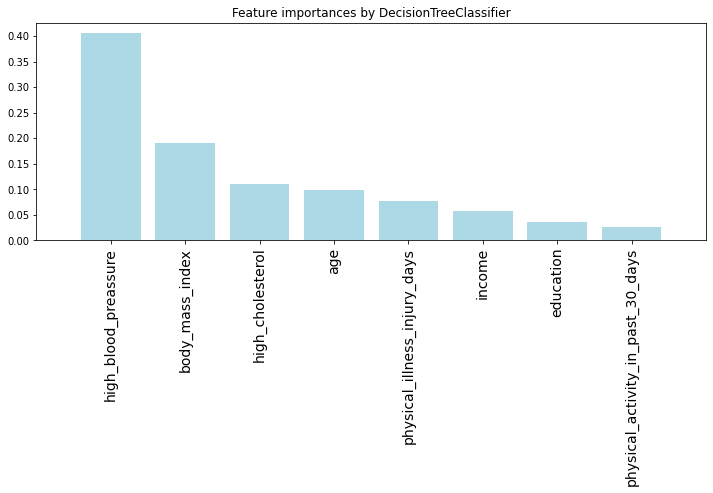

In [20]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Filtrando apenas os atributos relevantes.

In [21]:
X = df_diabetes_indcators[["high_blood_preassure","body_mass_index","high_cholesterol","age", 
                           "physical_illness_injury_days", "income", "education", "physical_activity_in_past_30_days"]]

#### Realizando balanceamento de classes.

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [23]:
nm = NearMiss(sampling_strategy=0.40)

In [24]:
x_nm, y_nm = nm.fit_resample(X, y)

In [25]:
smote = SMOTE(sampling_strategy=0.60, random_state=33)

In [26]:
x_smote, y_smote = smote.fit_resample(x_nm, y_nm)

#### Separando os conjuntos de dados.

In [27]:
y_smote.value_counts()

0    87742
1    52645
Name: diabetes, dtype: int64

In [581]:
scaler = MinMaxScaler()

In [582]:
X = scaler.fit_transform(x_smote)

In [583]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y_smote
       ,test_size = 0.2
       ,random_state = 123
)

#### Função do modelo de base.

In [413]:
def base_rate_model(X) :
    return np.zeros(X.shape[0])

#### Importando métodos de métrica de avaliação.

In [414]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [415]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de baseline

In [416]:
y_predict = base_rate_model(X_test)

In [417]:
roc_classification_report_results("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.62      1.00      0.77     22544
           1       0.00      0.00      0.00     13685

    accuracy                           0.62     36229
   macro avg       0.31      0.50      0.38     36229
weighted avg       0.39      0.62      0.48     36229



C:\Users\Joaquim Aniceto\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo de Árvore de Decisão

#### Instânciando o algoritmo.

In [584]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [585]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

#### Calculando as predições.

In [586]:
y_predict = decision_tree.predict(X_test)

#### Avaliando o resultado.

In [587]:
roc_classification_report_results("Decision Tree", y_test, y_predict)


Decision Tree AUC = 0.6976525848435982

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     17507
           1       0.66      0.58      0.61     10571

    accuracy                           0.73     28078
   macro avg       0.71      0.70      0.70     28078
weighted avg       0.72      0.73      0.72     28078



### Modelo de Arvore Aleatória (Random Forest)

#### Instânciando o algoritmo.

In [588]:
from sklearn.ensemble import RandomForestClassifier

In [589]:
random_forest = RandomForestClassifier()

#### Realizando o treinamento.

In [590]:
random_forest.fit(X_train,y_train)

RandomForestClassifier()

#### Calculando as predições.

In [591]:
y_predict = random_forest.predict(X_test)

#### Avaliando o resultado.

In [592]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.699644566136679

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     17507
           1       0.66      0.58      0.62     10571

    accuracy                           0.73     28078
   macro avg       0.71      0.70      0.70     28078
weighted avg       0.72      0.73      0.73     28078



### Pycaret

In [ ]:
pip install pycaret

#### Importando os métodos.

In [29]:
from pycaret.classification import *
from imblearn.over_sampling import ADASYN

#### Definindo o Setup.

In [35]:
x_smote['diabetes']=y_smote
defined_setup = setup(x_smote
          ,target = "diabetes"
          ,normalize = False
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
         )


,Description,Value
0,session_id,8457
1,Target,diabetes
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(140387, 9)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


#### Comparando diferentes modelos.

In [31]:
best_model = compare_models(fold = 5,sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7071,0.7906,0.7694,0.5829,0.6633,0.4126,0.4252,4.4860
xgboost,Extreme Gradient Boosting,0.7085,0.7897,0.7599,0.5858,0.6616,0.4130,0.4238,6.2820
gbc,Gradient Boosting Classifier,0.7074,0.7882,0.7565,0.5851,0.6598,0.4105,0.4209,5.8920
rf,Random Forest Classifier,0.7077,0.7861,0.7529,0.5859,0.6590,0.4102,0.4201,5.2100
et,Extra Trees Classifier,0.7085,0.7861,0.7462,0.5877,0.6575,0.4099,0.4188,6.2320
dt,Decision Tree Classifier,0.7078,0.7854,0.7446,0.5871,0.6565,0.4085,0.4173,3.4480
lr,Logistic Regression,0.7072,0.7842,0.7339,0.5878,0.6528,0.4050,0.4125,4.0900
lda,Linear Discriminant Analysis,0.7066,0.7840,0.7417,0.5860,0.6547,0.4056,0.4142,3.5960
ada,Ada Boost Classifier,0.7076,0.7839,0.7295,0.5890,0.6517,0.4047,0.4116,4.1980
nb,Naive Bayes,0.7046,0.7651,0.5946,0.6087,0.6016,0.3670,0.3670,3.4260
